In [1]:
import re
import os
import random
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from spacy.util import compounding
from spacy.util import minibatch

import nltk
from nltk.corpus import stopwords
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [3]:
for dirname, _, filenames in os.walk('dataset/text2'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

dataset/text2\sample_submission.csv
dataset/text2\test.csv
dataset/text2\train.csv
dataset/text2\tweet-sentiment-extraction.zip


In [6]:
def random_colors(number_of_colors):
    """
    simple function for random color generation
    input: number_of_colors - integer value indicating the number of colors 
    which are going to be generated
    
    output:
    color in the following format: [#E86DA4]
    """
    colors = []
    for i in range(number_of_colors):
        colors.append('#' +''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

In [8]:
# read the data

train = pd.read_csv('dataset/text2/train.csv')
test = pd.read_csv('dataset/text2/test.csv')
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [10]:
train.shape, test.shape

((27481, 4), (3534, 3))

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
textID           27481 non-null object
text             27480 non-null object
selected_text    27480 non-null object
sentiment        27481 non-null object
dtypes: object(4)
memory usage: 858.9+ KB


In [12]:
train.dropna(inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
textID           27480 non-null object
text             27480 non-null object
selected_text    27480 non-null object
sentiment        27480 non-null object
dtypes: object(4)
memory usage: 1.0+ MB


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
textID       3534 non-null object
text         3534 non-null object
sentiment    3534 non-null object
dtypes: object(3)
memory usage: 83.0+ KB


In [9]:
train['sentiment'].value_counts()

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [14]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,47dde4db6b,#steel toe boots - Good to hear that you`re c...,good,neutral
freq,1,1,199,11117


In [15]:
train['sentiment'].value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [21]:
temp = train.groupby('sentiment').count()['text']
temp = temp.reset_index().sort_values(by='text', ascending=False)
temp.style.background_gradient(cmap='Purples')


,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


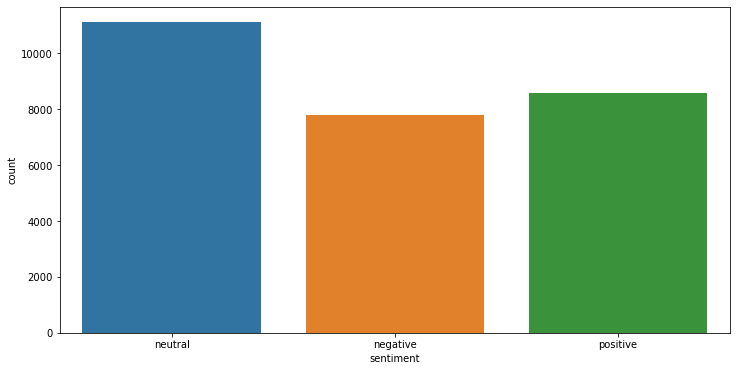

In [22]:
plt.figure(figsize=(12, 6))
sns.countplot(x='sentiment', data=train)

In [24]:
def clean_text(text):
    """
    Make text lowercase, remove text in square brackets
    remove links
    remove punctuation
    remove words containing numbers
    """
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

In [26]:
train['text'] = train['text'].apply(lambda x: clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x: clean_text(x))



In [27]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative
2,088c60f138,my boss is bullying me,bullying me,negative
3,9642c003ef,what interview leave me alone,leave me alone,negative
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative


In [28]:
train['temp_list'] = train['selected_text'].apply(lambda x: str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap='Blues')


,Common_words,count
0,i,7200
1,to,5306
2,the,4590
3,a,3538
4,my,2783
5,you,2624
6,and,2321
7,it,2158
8,is,2115
9,in,1986


In [29]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]



In [30]:
train['temp_list'] = train['temp_list'].apply(lambda x: remove_stopword(x))


In [31]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,good,1251
2,day,1058
3,love,909
4,happy,852
5,like,774
6,get,772
7,dont,765
8,go,700
9,cant,613
10,work,612


In [32]:
train['temp_list1'] = train['text'].apply(lambda x:str(x).split()) #List of words in every row for text
train['temp_list1'] = train['temp_list1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords

In [33]:
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
1,day,2044
2,good,1549
3,get,1426
4,like,1346
5,go,1267
6,dont,1200
7,love,1122
8,work,1112
9,going,1096
10,today,1096


In [36]:
# Most common words in different sentiments

positive_sent = train[train['sentiment'] == 'positive']
negative_sent = train[train['sentiment'] == 'negative']
neural_sent = train[train['sentiment'] == 'neutral']
positive_sent


,textID,text,selected_text,sentiment,temp_list,temp_list1
6,6e0c6d75b1,feedings for the baby are fun when he is all ...,fun,positive,[fun],"[feedings, baby, fun, smiles, coos]"
9,fc2cbefa9d,journey wow u just became cooler hehe is tha...,wow u just became cooler,positive,"[wow, u, became, cooler]","[journey, wow, u, became, cooler, hehe, possible]"
11,16fab9f95b,i really really like the song love story by ta...,like,positive,[like],"[really, really, like, song, love, story, tayl..."
21,e48b0b8a23,playing ghost online is really interesting the...,interesting,positive,[interesting],"[playing, ghost, online, really, interesting, ..."
25,e00c6ef376,the free fillin app on my ipod is fun im addicted,the free fillin app on my ipod is fun im addicted,positive,"[free, fillin, app, ipod, fun, im, addicted]","[free, fillin, app, ipod, fun, im, addicted]"
...,...,...,...,...,...,...
27467,432e6de6c9,morning twitfriends welcome to my new followers,welcome,positive,[welcome],"[morning, twitfriends, welcome, new, followers]"
27474,8f14bb2715,so i get up early and i feel good about the da...,i feel good ab,positive,"[feel, good, ab]","[get, early, feel, good, day, walk, work, im, ..."
27475,b78ec00df5,enjoy ur night,enjoy,positive,[enjoy],"[enjoy, ur, night]"
27478,f67aae2310,yay good for both of you enjoy the break you...,yay good for both of you,positive,"[yay, good]","[yay, good, enjoy, break, probably, need, hect..."


In [39]:
# positive sentiment 
top = Counter([item for sublist in positive_sent['temp_list1'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words', 'count']
temp_positive.style.background_gradient(cmap='Greens')



,Common_words,count
0,day,1223
1,good,1046
2,love,875
3,happy,840
4,im,740
5,mothers,627
6,thanks,553
7,great,478
8,like,413
9,hope,396


In [42]:
#MosT common negative words
top = Counter([item for sublist in negative_sent['temp_list1'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,like,476
2,dont,469
3,cant,463
4,get,436
5,miss,422
6,go,401
7,sad,389
8,work,386
9,sorry,340
10,really,339


In [44]:
#MosT common Neutral words
top = Counter([item for sublist in neural_sent['temp_list1'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Reds')

,Common_words,count
1,get,623
2,go,576
3,day,503
4,dont,491
5,going,479
6,work,477
7,like,457
8,lol,454
9,got,453
10,today,435


In [45]:
raw_text = [word for word_list in train['temp_list1'] for word in word_list]
raw_text

['id',
 'responded',
 'going',
 'sooo',
 'sad',
 'miss',
 'san',
 'diego',
 'boss',
 'bullying',
 'interview',
 'leave',
 'alone',
 'sons',
 'couldnt',
 'put',
 'releases',
 'already',
 'bought',
 'shameless',
 'plugging',
 'best',
 'rangers',
 'forum',
 'earth',
 'feedings',
 'baby',
 'fun',
 'smiles',
 'coos',
 'soooo',
 'high',
 'journey',
 'wow',
 'u',
 'became',
 'cooler',
 'hehe',
 'possible',
 'much',
 'love',
 'hopeful',
 'reckon',
 'chances',
 'minimal',
 'p',
 'im',
 'never',
 'gonna',
 'get',
 'cake',
 'stuff',
 'really',
 'really',
 'like',
 'song',
 'love',
 'story',
 'taylor',
 'swift',
 'sharpie',
 'running',
 'dangerously',
 'low',
 'ink',
 'want',
 'go',
 'music',
 'tonight',
 'lost',
 'voice',
 'test',
 'test',
 'lg',
 'uh',
 'oh',
 'sunburned',
 'sok',
 'trying',
 'plot',
 'alternatives',
 'speak',
 'sigh',
 'ive',
 'sick',
 'past',
 'days',
 'thus',
 'hair',
 'looks',
 'wierd',
 'didnt',
 'hat',
 'would',
 'look',
 'back',
 'home',
 'gonna',
 'miss',
 'every',
 'one

In [49]:
def words_unique(sentiment, numwords, raw_words):
    """
    Input:
    segment - Segment category (3 sentiment)
    numwords - how many specific words do you want to ee in the final result
    raw_words - list for item in train[train['sentiment'] == sentiment]['temp_list1']
    Output:
    datafram giving information about the name of specific ingredient
    """
    allother = []
    for item in train[train.sentiment != sentiment]['temp_list1']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words
            

In [50]:
unique_positive = words_unique('positive', 20, raw_text)
unique_positive.style.background_gradient(cmap='Greens')

,words,count
0,congratulations,29
1,thnx,10
2,appreciated,8
3,shared,7
4,presents,7
5,greetings,7
6,blessings,6
7,mothersday,6
8,mcr,6
9,coolest,6


In [51]:
Unique_Negative= words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


,words,count
0,ache,12
1,suffering,9
2,allergic,7
3,cramps,7
4,saddest,7
5,pissing,7
6,sob,6
7,dealing,6
8,devastated,6
9,noes,6


In [52]:
Unique_Neutral= words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


,words,count
0,settings,9
1,explain,7
2,mite,6
3,hiya,6
4,reader,5
5,pr,5
6,sorta,5
7,fathers,5
8,enterprise,5
9,guessed,5
